In [ ]:
!pip install linearmodels
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.stats.api as sms
from sklearn.metrics import mean_squared_error
from scipy import stats
from linearmodels.panel import PanelOLS, RandomEffects
from scipy.stats import chi2
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import t

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.2/94.2 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 3.1 MB/s eta 0:00:00


# MD Functions

In [ ]:
# panel effects detection
def panel_effects(y, X, w):
    ols_results = PanelOLS(y, X, weights = w).fit()
    lm_stat, lm_p, f_stat, f_p = sms.het_breuschpagan(ols_results.resids, X)
    fe_results = PanelOLS(y, X, weights = w, entity_effects=True, time_effects=True).fit()
    print("lm_p: ", lm_p)
    print("f_p: ", f_p)
    print(fe_results.f_pooled)

# fixed effects and random effects selection
def hausman_test(y, X, w):
    fe_results = PanelOLS(y, X, weights = w, entity_effects=True, time_effects=True).fit()
    re_results = RandomEffects(y, X, weights = w).fit()

    fe_coeffs = fe_results.params
    re_coeffs = re_results.params
    fe_cov = fe_results.cov
    re_cov = re_results.cov

    diff_coeffs = fe_coeffs - re_coeffs
    var_diff_coeffs = fe_cov - re_cov
    hausman_statistic = diff_coeffs.dot(np.linalg.inv(var_diff_coeffs)).dot(diff_coeffs)
    degrees_of_freedom = len(fe_coeffs)
    critical_value = chi2.ppf(0.95, degrees_of_freedom)

    p_value = 1 - chi2.cdf(hausman_statistic, degrees_of_freedom)
    print(p_value)
    if p_value < 0.05:
        print("Fixed effects model is more appropriate")

# model assumptions check
def model_assumption(y, X, w, p):
    wls_results = sm.WLS(y, X, weights = w).fit(cov_type = 'HC1')

    # heteroscedasticity
    lm, lm_pvalue, fvalue, f_pvalue = het_breuschpagan(wls_results.resid, X)
    print("Breusch-Pagan test p-value:", lm_pvalue)

    # serial correlation
    dw_statistic = sm.stats.stattools.durbin_watson(wls_results.resid)
    print("Durbin-Watson test statistic:", dw_statistic)

    # VIF
    vif_df = pd.DataFrame()
    vif_results = []
    params = p
    for col in params:
        other_cols = [c for c in X.columns if c != col]
        X_partial = sm.add_constant(X[other_cols])
        wls_results = sm.WLS(X[col], X[other_cols], weights = w).fit(cov_type = 'HC1')
        vif = 1 / (1 - wls_results.rsquared_adj)
        vif_results.append(vif)

    vif_df['features'] = params
    vif_df['vif'] = vif_results
    print(vif_df)

# plot residuals against fitted values
def res_plot(y, X, w, outcome):
    wls_results = sm.WLS(y, X, weights = w).fit(cov_type = 'HC1')
    sns.set(rc={'figure.figsize':(7.5,4.5)})
    sns.set(font_scale =1.2)
    sns.scatterplot(x = (wls_results.fittedvalues), y=(wls_results.resid),color = 'orange')
    sns.lineplot(x = [wls_results.fittedvalues.min(),wls_results.fittedvalues.max()],y = [0,0],color = 'blue')
    plt.xlabel('Fitted values')
    plt.ylabel('Residuals')
    plt.savefig(f"{outcome}_res.png")

# compute studentized residuals
def compute_studentized_residuals(residuals):
    studentized_residuals = np.zeros_like(residuals)
    for i, res in enumerate(residuals):
        std_residuals = np.std(np.delete(residuals.array, i))
        studentized_residuals[i] = res / std_residuals
    return studentized_residuals

# plot studentized residuals against fitted values
def studentized_res_plot(y, X, w, outcome):
    wls_results = sm.WLS(y, X, weights = w).fit(cov_type = 'HC1')
    n = len(y)
    p = wls_results.df_model
    alpha = 0.05
    critical_value = stats.t.ppf(1-alpha/(2*n), n - p - 1)
    student_resid = compute_studentized_residuals(wls_results.resid)

    sns.set(font_scale =1.2)
    sns.scatterplot(x = (wls_results.fittedvalues), y=(student_resid),color = 'orange')
    sns.lineplot(x = [wls_results.fittedvalues.min(),wls_results.fittedvalues.max()],y = [0,0],color = 'blue')
    ax = sns.lineplot(x = [wls_results.fittedvalues.min(),wls_results.fittedvalues.max()],
                      y = [critical_value, critical_value], color = 'green')
    sns.lineplot(x = [wls_results.fittedvalues.min(),wls_results.fittedvalues.max()],
                 y = [-critical_value, -critical_value], color = 'green')
    ax.lines[1].set_linestyle("--")
    ax.lines[2].set_linestyle("--")

    plt.xlabel('Fitted values')
    plt.ylabel('Studentized Residuals')
    plt.savefig(f"{outcome}_studentized_res.png")

def cooks_distance(y, X, w, outcome):
    wls_results = sm.WLS(y, X, weights = w).fit(cov_type = 'HC1')
    leverage = np.diag(np.dot(np.dot(X, np.linalg.inv(np.dot(np.transpose(X), X))), np.transpose(X)))
    residuals = wls_results.resid
    n = len(y)
    p = X.shape[1] - 1
    mse = np.mean(residuals**2)
    cooks_distance = (residuals**2 * leverage) / (p * mse * (1 - leverage)**2)
    print("Critical value:", stats.f.ppf(0.5, p, n-p-1))
    sns.set(font_scale =1.2)
    sns.lineplot(x = range(n), y = cooks_distance)
    plt.xlabel('Observation index')
    plt.ylabel("Cook's Distance (model)")
    plt.savefig(f"{outcome}_cooks.png")

# Math Proficiency Rate

In [ ]:
in_math = pd.read_csv('new_indiana_mathpass.csv')
il = pd.read_csv('illinois_all.csv')
wi = pd.read_csv('wisconsin_all.csv')
data = pd.concat([in_math, il, wi]).loc[:, ['year', 'mergecode', 'state', 'totaltest', 'mathpass',
                                            'virtualper', 'hybridper', 'black', 'hispanic',
                                            'white', 'lowincome']].reset_index().drop(columns = 'index')

dummy_variables = pd.get_dummies(data[['state']], drop_first = True, dtype = 'int')
data = pd.concat([data, dummy_variables], axis=1).drop(columns = ['state'])
data['in_virtual'] = data['state_indiana'] * data['virtualper']
data['wi_virtual'] = data['state_wisconsin'] * data['virtualper']
data['in_hybrid'] = data['state_indiana'] * data['hybridper']
data['wi_hybrid'] = data['state_wisconsin'] * data['hybridper']

data['year'] = pd.to_datetime(data['year'], format='%y')
data = data.drop(columns = ['state_indiana', 'state_wisconsin']).set_index(['mergecode', 'year'])

data['black_virtual'] = data['black'] * data['virtualper']
data['black_hybrid'] = data['black'] * data['hybridper']
data['hispanic_virtual'] = data['hispanic'] * data['virtualper']
data['hispanic_hybrid'] = data['hispanic'] * data['hybridper']
data['lowincome_virtual'] = data['lowincome'] * data['virtualper']
data['lowincome_hybrid'] = data['lowincome'] * data['hybridper']

exog = data.drop(columns = ['totaltest', 'mathpass'])
exog = sm.add_constant(exog)

In [ ]:
panel_effects(data.mathpass, exog, data.totaltest)
hausman_test(data.mathpass, exog, data.totaltest)

lm_p:  6.747665179927255e-121
f_p:  2.9361254944434576e-128
Pooled F-statistic
H0: Effects are zero
Statistic: 19.4715
P-value: 0.0000
Distributed: F(1433,4274)
0.0
Fixed effects model is more appropriate


In [ ]:
drop = pd.read_csv('math_drop.csv').math_drop.to_list()
in_math = pd.read_csv('new_indiana_mathpass.csv')
il = pd.read_csv('illinois_all.csv')
wi = pd.read_csv('wisconsin_all.csv')
data = pd.concat([in_math, il, wi]).loc[:, ['year', 'mergecode', 'state', 'totaltest', 'mathpass',
                                            'virtualper', 'hybridper', 'black', 'hispanic',
                                            'white', 'lowincome']]
data = data.loc[~data['mergecode'].isin(drop), :].reset_index().drop(columns = 'index')
dummy_variables = pd.get_dummies(data[['state']], drop_first = True, dtype = 'int')
data = pd.concat([data, dummy_variables], axis=1).drop(columns = ['state'])
data['in_virtual'] = data['state_indiana'] * data['virtualper']
data['wi_virtual'] = data['state_wisconsin'] * data['virtualper']
data['in_hybrid'] = data['state_indiana'] * data['hybridper']
data['wi_hybrid'] = data['state_wisconsin'] * data['hybridper']

data['year'] = pd.to_datetime(data['year'], format='%y')
data = data.drop(columns = ['state_indiana', 'state_wisconsin']).set_index(['mergecode', 'year'])

data['black_virtual'] = data['black'] * data['virtualper']
data['black_hybrid'] = data['black'] * data['hybridper']
data['hispanic_virtual'] = data['hispanic'] * data['virtualper']
data['hispanic_hybrid'] = data['hispanic'] * data['hybridper']
data['lowincome_virtual'] = data['lowincome'] * data['virtualper']
data['lowincome_hybrid'] = data['lowincome'] * data['hybridper']

exog = data.drop(columns = ['totaltest', 'mathpass'])
exog = sm.add_constant(exog)

In [ ]:
panel_effects(data.mathpass, exog, data.totaltest)
hausman_test(data.mathpass, exog, data.totaltest)

lm_p:  9.081156100082276e-50
f_p:  2.769880394352576e-51
Pooled F-statistic
H0: Effects are zero
Statistic: 17.8888
P-value: 0.0000
Distributed: F(1270,3785)
0.0
Fixed effects model is more appropriate


In [ ]:
in_math = pd.read_csv('new_indiana_mathpass.csv')
il = pd.read_csv('illinois_all.csv')
wi = pd.read_csv('wisconsin_all.csv')
data = pd.concat([in_math, il, wi]).loc[:, ['year', 'mergecode', 'state', 'totaltest', 'mathpass',
                                            'virtualper', 'hybridper', 'black', 'hispanic',
                                            'white', 'lowincome']]
data['year'] = data['year'].astype('str')

dummy_variables = pd.get_dummies(data[['year', 'mergecode', 'state']], drop_first = True, dtype = 'int')
data = pd.concat([data, dummy_variables], axis=1).drop(columns = ['state', 'year', 'mergecode'])
data['in_virtual'] = data['state_indiana'] * data['virtualper']
data['wi_virtual'] = data['state_wisconsin'] * data['virtualper']
data['in_hybrid'] = data['state_indiana'] * data['hybridper']
data['wi_hybrid'] = data['state_wisconsin'] * data['hybridper']

data = data.drop(columns = ['state_indiana', 'state_wisconsin'])

data['black_virtual'] = data['black'] * data['virtualper']
data['black_hybrid'] = data['black'] * data['hybridper']
data['hispanic_virtual'] = data['hispanic'] * data['virtualper']
data['hispanic_hybrid'] = data['hispanic'] * data['hybridper']
data['lowincome_virtual'] = data['lowincome'] * data['virtualper']
data['lowincome_hybrid'] = data['lowincome'] * data['hybridper']

exog = data.drop(columns = ['totaltest', 'mathpass'])
exog = sm.add_constant(exog)

In [ ]:
params = ['virtualper', 'hybridper', 'in_virtual', 'wi_virtual', 'in_hybrid', 'wi_hybrid',
          'black_virtual', 'black_hybrid', 'hispanic_virtual', 'hispanic_hybrid', 'lowincome_virtual', 'lowincome_hybrid']
model_assumption(data.mathpass, exog, data.totaltest, params)

Breusch-Pagan test p-value: 5.832891926717901e-53
Durbin-Watson test statistic: 2.291983220749217
             features        vif
0          virtualper   9.188351
1           hybridper   5.275548
2          in_virtual   1.572015
3          wi_virtual   1.792150
4           in_hybrid   1.218366
5           wi_hybrid   1.582515
6       black_virtual   6.060652
7        black_hybrid   2.263902
8    hispanic_virtual   9.846470
9     hispanic_hybrid   3.519608
10  lowincome_virtual  18.338592
11   lowincome_hybrid   7.736469


In [ ]:
drop = pd.read_csv('math_drop.csv').math_drop.to_list()
in_math = pd.read_csv('new_indiana_mathpass.csv')
il = pd.read_csv('illinois_all.csv')
wi = pd.read_csv('wisconsin_all.csv')
data = pd.concat([in_math, il, wi]).loc[:, ['year', 'mergecode', 'state', 'totaltest', 'mathpass',
                                            'virtualper', 'hybridper', 'black', 'hispanic',
                                            'white', 'lowincome']]
data['year'] = data['year'].astype('str')

data = data.loc[~data['mergecode'].isin(drop), :].reset_index().drop(columns = 'index')

dummy_variables = pd.get_dummies(data[['year', 'mergecode', 'state']], drop_first = True, dtype = 'int')
data = pd.concat([data, dummy_variables], axis=1).drop(columns = ['state', 'year', 'mergecode'])
data['in_virtual'] = data['state_indiana'] * data['virtualper']
data['wi_virtual'] = data['state_wisconsin'] * data['virtualper']
data['in_hybrid'] = data['state_indiana'] * data['hybridper']
data['wi_hybrid'] = data['state_wisconsin'] * data['hybridper']

data = data.drop(columns = ['state_indiana', 'state_wisconsin'])

data['black_virtual'] = data['black'] * data['virtualper']
data['black_hybrid'] = data['black'] * data['hybridper']
data['hispanic_virtual'] = data['hispanic'] * data['virtualper']
data['hispanic_hybrid'] = data['hispanic'] * data['hybridper']
data['lowincome_virtual'] = data['lowincome'] * data['virtualper']
data['lowincome_hybrid'] = data['lowincome'] * data['hybridper']

exog = data.drop(columns = ['totaltest', 'mathpass'])
exog = sm.add_constant(exog)

In [ ]:
params = ['virtualper', 'hybridper', 'in_virtual', 'wi_virtual', 'in_hybrid', 'wi_hybrid',
          'black_virtual', 'black_hybrid','hispanic_virtual', 'hispanic_hybrid', 'lowincome_virtual', 'lowincome_hybrid']
model_assumption(data.mathpass, exog, data.totaltest, params)

Breusch-Pagan test p-value: 1.7853241130589782e-44
Durbin-Watson test statistic: 2.314514879529525
             features        vif
0          virtualper   9.482519
1           hybridper   6.943957
2          in_virtual   1.534271
3          wi_virtual   1.816855
4           in_hybrid   1.326370
5           wi_hybrid   1.560705
6       black_virtual  10.565814
7        black_hybrid   2.845633
8    hispanic_virtual  13.960519
9     hispanic_hybrid   3.824853
10  lowincome_virtual  30.209319
11   lowincome_hybrid  10.809082


In [ ]:
drop = pd.read_csv('math_drop.csv').math_drop.to_list()
in_math = pd.read_csv('new_indiana_mathpass.csv')
il = pd.read_csv('illinois_all.csv')
wi = pd.read_csv('wisconsin_all.csv')
data = pd.concat([in_math, il, wi]).loc[:, ['year', 'mergecode', 'state', 'totaltest', 'mathpass',
                                            'virtualper', 'hybridper', 'black', 'hispanic',
                                            'white', 'lowincome']]
data['year'] = data['year'].astype('str')

data = data.loc[~data['mergecode'].isin(drop), :].reset_index().drop(columns = 'index')

dummy_variables = pd.get_dummies(data[['year', 'mergecode', 'state']], drop_first = True, dtype = 'int')
data = pd.concat([data, dummy_variables], axis=1).drop(columns = ['state', 'year', 'mergecode'])
data['in_virtual'] = data['state_indiana'] * data['virtualper']
data['wi_virtual'] = data['state_wisconsin'] * data['virtualper']
data['in_hybrid'] = data['state_indiana'] * data['hybridper']
data['wi_hybrid'] = data['state_wisconsin'] * data['hybridper']

data = data.drop(columns = ['state_indiana', 'state_wisconsin'])

data['black_virtual'] = data['black'] * data['virtualper']
data['black_hybrid'] = data['black'] * data['hybridper']
data['hispanic_virtual'] = data['hispanic'] * data['virtualper']
data['hispanic_hybrid'] = data['hispanic'] * data['hybridper']
# removed % ED * % Virtual
data['lowincome_hybrid'] = data['lowincome'] * data['hybridper']

exog = data.drop(columns = ['totaltest', 'mathpass'])
exog = sm.add_constant(exog)

In [ ]:
params = ['virtualper', 'hybridper', 'in_virtual', 'wi_virtual', 'in_hybrid', 'wi_hybrid',
          'black_virtual', 'black_hybrid', 'hispanic_virtual', 'hispanic_hybrid', 'lowincome_hybrid']
model_assumption(data.mathpass, exog, data.totaltest, params)

Breusch-Pagan test p-value: 1.6311363472447222e-44
Durbin-Watson test statistic: 2.3145356183098547
            features       vif
0         virtualper  8.977782
1          hybridper  6.509944
2         in_virtual  1.521364
3         wi_virtual  1.648913
4          in_hybrid  1.317173
5          wi_hybrid  1.550241
6      black_virtual  2.982744
7       black_hybrid  2.728508
8   hispanic_virtual  4.946092
9    hispanic_hybrid  3.742443
10  lowincome_hybrid  9.325140


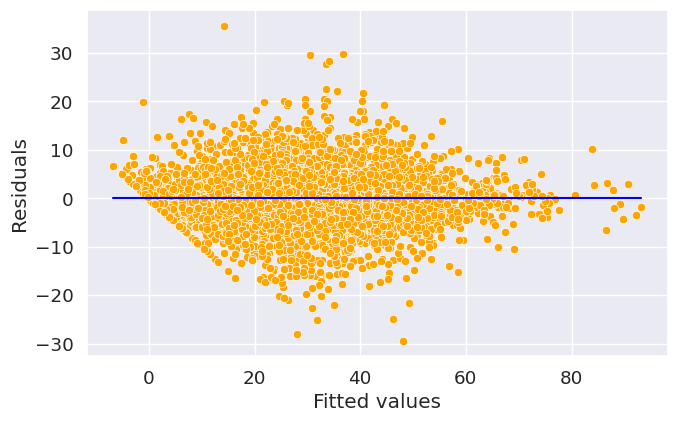

In [ ]:
res_plot(data.mathpass, exog, data.totaltest, "math")

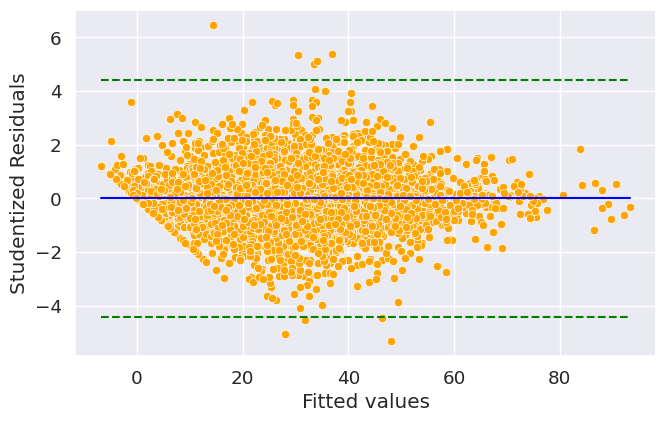

In [ ]:
studentized_res_plot(data.mathpass, exog, data.totaltest, "math")

Critical value: 0.9996572666172356


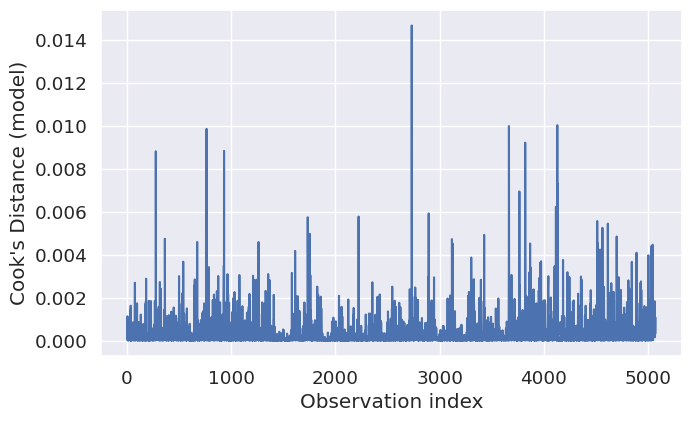

In [ ]:
cooks_distance(data.mathpass, exog, data.totaltest, "math")

# ELA Proficiency Rate

In [ ]:
in_ela = pd.read_csv('new_indiana_elapass.csv')
il = pd.read_csv('illinois_all.csv')
wi = pd.read_csv('wisconsin_all.csv')
data = pd.concat([in_ela, il, wi]).loc[:, ['year', 'mergecode', 'state', 'totaltest', 'elapass',
                                            'virtualper', 'hybridper', 'black', 'hispanic',
                                            'white', 'lowincome']].reset_index().drop(columns = 'index')

dummy_variables = pd.get_dummies(data[['state']], drop_first = True, dtype = 'int')
data = pd.concat([data, dummy_variables], axis=1).drop(columns = ['state'])
data['in_virtual'] = data['state_indiana'] * data['virtualper']
data['wi_virtual'] = data['state_wisconsin'] * data['virtualper']
data['in_hybrid'] = data['state_indiana'] * data['hybridper']
data['wi_hybrid'] = data['state_wisconsin'] * data['hybridper']

data['year'] = pd.to_datetime(data['year'], format='%y')
data = data.drop(columns = ['state_indiana', 'state_wisconsin']).set_index(['mergecode', 'year'])

data['black_virtual'] = data['black'] * data['virtualper']
data['black_hybrid'] = data['black'] * data['hybridper']
data['hispanic_virtual'] = data['hispanic'] * data['virtualper']
data['hispanic_hybrid'] = data['hispanic'] * data['hybridper']
data['lowincome_virtual'] = data['lowincome'] * data['virtualper']
data['lowincome_hybrid'] = data['lowincome'] * data['hybridper']

exog = data.drop(columns = ['totaltest', 'elapass'])
exog = sm.add_constant(exog)

In [ ]:
panel_effects(data.elapass, exog, data.totaltest)
hausman_test(data.elapass, exog, data.totaltest)

lm_p:  2.3512856157942754e-87
f_p:  2.9390283677631256e-91
Pooled F-statistic
H0: Effects are zero
Statistic: 31.9118
P-value: 0.0000
Distributed: F(1433,4274)
0.0
Fixed effects model is more appropriate


In [ ]:
drop = pd.read_csv('ela_inf_remove.csv').ela_drop.to_list()
in_ela = pd.read_csv('new_indiana_elapass.csv')
il = pd.read_csv('illinois_all.csv')
wi = pd.read_csv('wisconsin_all.csv')
data = pd.concat([in_ela, il, wi]).loc[:, ['year', 'mergecode', 'state', 'totaltest', 'elapass',
                                            'virtualper', 'hybridper', 'black', 'hispanic',
                                            'white', 'lowincome']]
data = data.loc[~data['mergecode'].isin(drop), :].reset_index().drop(columns = 'index')
dummy_variables = pd.get_dummies(data[['state']], drop_first = True, dtype = 'int')
data = pd.concat([data, dummy_variables], axis=1).drop(columns = ['state'])
data['in_virtual'] = data['state_indiana'] * data['virtualper']
data['wi_virtual'] = data['state_wisconsin'] * data['virtualper']
data['in_hybrid'] = data['state_indiana'] * data['hybridper']
data['wi_hybrid'] = data['state_wisconsin'] * data['hybridper']

data['year'] = pd.to_datetime(data['year'], format='%y')
data = data.drop(columns = ['state_indiana', 'state_wisconsin']).set_index(['mergecode', 'year'])

data['black_virtual'] = data['black'] * data['virtualper']
data['black_hybrid'] = data['black'] * data['hybridper']
data['hispanic_virtual'] = data['hispanic'] * data['virtualper']
data['hispanic_hybrid'] = data['hispanic'] * data['hybridper']
data['lowincome_virtual'] = data['lowincome'] * data['virtualper']
data['lowincome_hybrid'] = data['lowincome'] * data['hybridper']

exog = data.drop(columns = ['totaltest', 'elapass'])
exog = sm.add_constant(exog)

In [ ]:
panel_effects(data.elapass, exog, data.totaltest)
hausman_test(data.elapass, exog, data.totaltest)

lm_p:  1.4223893604432561e-87
f_p:  8.08391775308705e-92
Pooled F-statistic
H0: Effects are zero
Statistic: 32.4671
P-value: 0.0000
Distributed: F(1330,3965)
0.0
Fixed effects model is more appropriate


In [ ]:
in_ela = pd.read_csv('new_indiana_elapass.csv')
il = pd.read_csv('illinois_all.csv')
wi = pd.read_csv('wisconsin_all.csv')
data = pd.concat([in_ela, il, wi]).loc[:, ['year', 'mergecode', 'state', 'totaltest', 'elapass',
                                            'virtualper', 'hybridper', 'black', 'hispanic',
                                            'white', 'lowincome']]
data['year'] = data['year'].astype('str')

dummy_variables = pd.get_dummies(data[['year', 'mergecode', 'state']], drop_first = True, dtype = 'int')
data = pd.concat([data, dummy_variables], axis=1).drop(columns = ['state', 'year', 'mergecode'])
data['in_virtual'] = data['state_indiana'] * data['virtualper']
data['wi_virtual'] = data['state_wisconsin'] * data['virtualper']
data['in_hybrid'] = data['state_indiana'] * data['hybridper']
data['wi_hybrid'] = data['state_wisconsin'] * data['hybridper']

data = data.drop(columns = ['state_indiana', 'state_wisconsin'])

data['black_virtual'] = data['black'] * data['virtualper']
data['black_hybrid'] = data['black'] * data['hybridper']
data['hispanic_virtual'] = data['hispanic'] * data['virtualper']
data['hispanic_hybrid'] = data['hispanic'] * data['hybridper']
data['lowincome_virtual'] = data['lowincome'] * data['virtualper']
data['lowincome_hybrid'] = data['lowincome'] * data['hybridper']

exog = data.drop(columns = ['totaltest', 'elapass'])
exog = sm.add_constant(exog)

In [ ]:
params = ['virtualper', 'hybridper', 'in_virtual', 'wi_virtual', 'in_hybrid', 'wi_hybrid',
          'black_virtual', 'black_hybrid', 'hispanic_virtual', 'hispanic_hybrid', 'lowincome_virtual', 'lowincome_hybrid']
model_assumption(data.elapass, exog, data.totaltest, params)

Breusch-Pagan test p-value: 1.9990924586473405e-43
Durbin-Watson test statistic: 2.3768247054208853
             features        vif
0          virtualper   9.189275
1           hybridper   5.276984
2          in_virtual   1.562923
3          wi_virtual   1.792569
4           in_hybrid   1.214142
5           wi_hybrid   1.582639
6       black_virtual   6.057062
7        black_hybrid   2.262586
8    hispanic_virtual   9.849091
9     hispanic_hybrid   3.519957
10  lowincome_virtual  18.322373
11   lowincome_hybrid   7.734046


In [ ]:
drop = pd.read_csv('ela_inf_remove.csv').ela_drop.to_list()
in_ela = pd.read_csv('new_indiana_elapass.csv')
il = pd.read_csv('illinois_all.csv')
wi = pd.read_csv('wisconsin_all.csv')
data = pd.concat([in_ela, il, wi]).loc[:, ['year', 'mergecode', 'state', 'totaltest', 'elapass',
                                            'virtualper', 'hybridper', 'black', 'hispanic',
                                            'white', 'lowincome']]
data = data.loc[~data['mergecode'].isin(drop), :].reset_index().drop(columns = 'index')
data['year'] = data['year'].astype('str')
dummy_variables = pd.get_dummies(data[['year', 'mergecode', 'state']], drop_first = True, dtype = 'int')
data = pd.concat([data, dummy_variables], axis=1).drop(columns = ['state', 'year', 'mergecode'])
data['in_virtual'] = data['state_indiana'] * data['virtualper']
data['wi_virtual'] = data['state_wisconsin'] * data['virtualper']
data['in_hybrid'] = data['state_indiana'] * data['hybridper']
data['wi_hybrid'] = data['state_wisconsin'] * data['hybridper']

data = data.drop(columns = ['state_indiana', 'state_wisconsin'])

data['black_virtual'] = data['black'] * data['virtualper']
data['black_hybrid'] = data['black'] * data['hybridper']
data['hispanic_virtual'] = data['hispanic'] * data['virtualper']
data['hispanic_hybrid'] = data['hispanic'] * data['hybridper']
data['lowincome_virtual'] = data['lowincome'] * data['virtualper']
data['lowincome_hybrid'] = data['lowincome'] * data['hybridper']

exog = data.drop(columns = ['totaltest', 'elapass'])
exog = sm.add_constant(exog)

In [ ]:
params = ['virtualper', 'hybridper', 'in_virtual', 'wi_virtual', 'in_hybrid', 'wi_hybrid',
          'black_virtual', 'black_hybrid', 'hispanic_virtual', 'hispanic_hybrid', 'lowincome_virtual', 'lowincome_hybrid']
model_assumption(data.elapass, exog, data.totaltest, params)

Breusch-Pagan test p-value: 9.86919192794669e-41
Durbin-Watson test statistic: 2.392963048281802
             features        vif
0          virtualper   9.094880
1           hybridper   5.050674
2          in_virtual   1.635246
3          wi_virtual   1.678285
4           in_hybrid   1.319677
5           wi_hybrid   1.465145
6       black_virtual   6.013782
7        black_hybrid   2.335063
8    hispanic_virtual   9.598500
9     hispanic_hybrid   3.668031
10  lowincome_virtual  16.295133
11   lowincome_hybrid   8.198381


In [ ]:
drop = pd.read_csv('ela_inf_remove.csv').ela_drop.to_list()
in_ela = pd.read_csv('new_indiana_elapass.csv')
il = pd.read_csv('illinois_all.csv')
wi = pd.read_csv('wisconsin_all.csv')
data = pd.concat([in_ela, il, wi]).loc[:, ['year', 'mergecode', 'state', 'totaltest', 'elapass',
                                            'virtualper', 'hybridper', 'black', 'hispanic',
                                            'white', 'lowincome']]
data = data.loc[~data['mergecode'].isin(drop), :].reset_index().drop(columns = 'index')
data['year'] = data['year'].astype('str')
dummy_variables = pd.get_dummies(data[['year', 'mergecode', 'state']], drop_first = True, dtype = 'int')
data = pd.concat([data, dummy_variables], axis=1).drop(columns = ['state', 'year', 'mergecode'])
data['in_virtual'] = data['state_indiana'] * data['virtualper']
data['wi_virtual'] = data['state_wisconsin'] * data['virtualper']
data['in_hybrid'] = data['state_indiana'] * data['hybridper']
data['wi_hybrid'] = data['state_wisconsin'] * data['hybridper']

data = data.drop(columns = ['state_indiana', 'state_wisconsin'])

data['black_virtual'] = data['black'] * data['virtualper']
data['black_hybrid'] = data['black'] * data['hybridper']
data['hispanic_virtual'] = data['hispanic'] * data['virtualper']
data['hispanic_hybrid'] = data['hispanic'] * data['hybridper']
# removed % ED * % Virtual
data['lowincome_hybrid'] = data['lowincome'] * data['hybridper']

exog = data.drop(columns = ['totaltest', 'elapass'])
exog = sm.add_constant(exog)

In [ ]:
params = ['virtualper', 'hybridper', 'in_virtual', 'wi_virtual', 'in_hybrid', 'wi_hybrid',
          'black_virtual', 'black_hybrid', 'hispanic_virtual', 'hispanic_hybrid', 'lowincome_hybrid']
model_assumption(data.elapass, exog, data.totaltest, params)

Breusch-Pagan test p-value: 1.0329840807411332e-40
Durbin-Watson test statistic: 2.393094779935937
            features       vif
0         virtualper  8.841346
1          hybridper  4.927730
2         in_virtual  1.590395
3         wi_virtual  1.524426
4          in_hybrid  1.319466
5          wi_hybrid  1.453023
6      black_virtual  2.804074
7       black_hybrid  2.315107
8   hispanic_virtual  4.310270
9    hispanic_hybrid  3.523451
10  lowincome_hybrid  7.461110


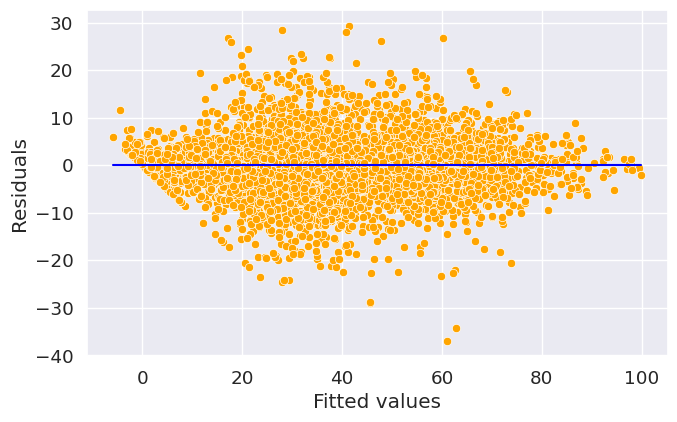

In [ ]:
res_plot(data.elapass, exog, data.totaltest, "ela")

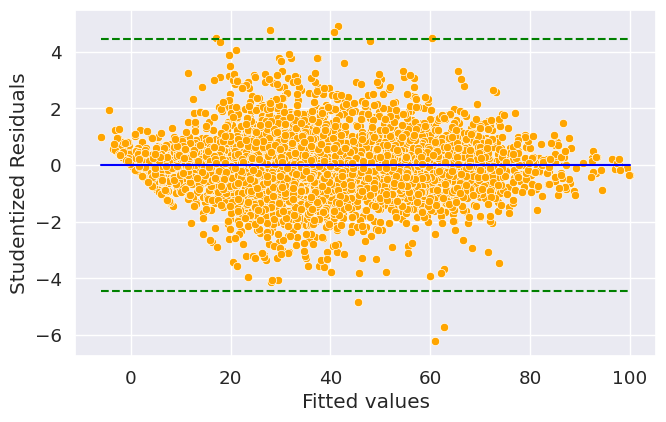

In [ ]:
studentized_res_plot(data.elapass, exog, data.totaltest, "ela")

Critical value: 0.9996724197989071


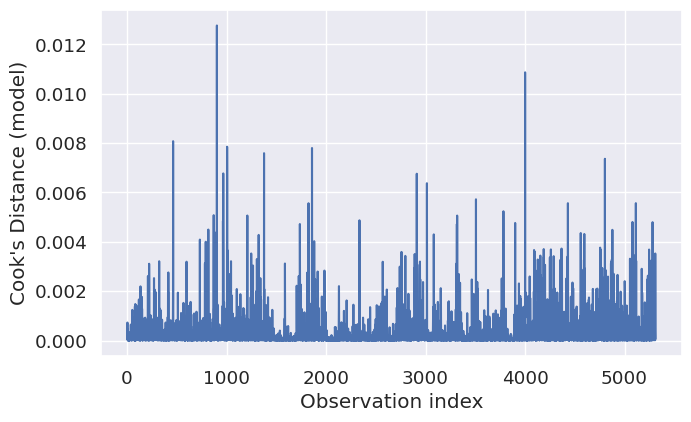

In [ ]:
cooks_distance(data.elapass, exog, data.totaltest, "ela")

# Dropout Rate

In [ ]:
az = pd.read_csv('arizona_dropout.csv')
co = pd.read_csv('colorado_dropout.csv')
ga = pd.read_csv('georgia_dropout.csv')
wi = pd.read_csv('wisconsin_all.csv')
data = pd.concat([az, co, ga, wi]).loc[:, ['year', 'mergecode', 'state', 'totalenroll', 'droprate',
                                            'virtualper', 'hybridper', 'black', 'hispanic',
                                            'white', 'lowincome']].reset_index().drop(columns = 'index')

dummy_variables = pd.get_dummies(data[['state']], drop_first = True, dtype = 'int')
data = pd.concat([data, dummy_variables], axis=1).drop(columns = ['state'])
data['co_virtual'] = data['state_colorado'] * data['virtualper']
data['ga_virtual'] = data['state_georgia'] * data['virtualper']
data['wi_virtual'] = data['state_wisconsin'] * data['virtualper']
data['co_hybrid'] = data['state_colorado'] * data['hybridper']
data['ga_hybrid'] = data['state_georgia'] * data['hybridper']
data['wi_hybrid'] = data['state_wisconsin'] * data['hybridper']

data['year'] = pd.to_datetime(data['year'], format='%y')
data = data.drop(columns = ['state_colorado', 'state_georgia', 'state_wisconsin']).set_index(['mergecode', 'year'])

data['black_virtual'] = data['black'] * data['virtualper']
data['black_hybrid'] = data['black'] * data['hybridper']
data['hispanic_virtual'] = data['hispanic'] * data['virtualper']
data['hispanic_hybrid'] = data['hispanic'] * data['hybridper']
data['lowincome_virtual'] = data['lowincome'] * data['virtualper']
data['lowincome_hybrid'] = data['lowincome'] * data['hybridper']

exog = data.drop(columns = ['totalenroll', 'droprate'])
exog = sm.add_constant(exog)

In [ ]:
panel_effects(data.droprate, exog, data.totalenroll)

lm_p:  1.5808881863108324e-64
f_p:  7.910969696792309e-67
Pooled F-statistic
H0: Effects are zero
Statistic: 46.8976
P-value: 0.0000
Distributed: F(1400,4173)


In [ ]:
drop = pd.read_csv('drop_inf_remove.csv').drop_drop.to_list()
az = pd.read_csv('arizona_dropout.csv')
co = pd.read_csv('colorado_dropout.csv')
ga = pd.read_csv('georgia_dropout.csv')
wi = pd.read_csv('wisconsin_all.csv')
data = pd.concat([az, co, ga, wi]).loc[:, ['year', 'mergecode', 'state', 'totalenroll', 'droprate',
                                            'virtualper', 'hybridper', 'black', 'hispanic',
                                            'white', 'lowincome']]

data = data.loc[~data['mergecode'].isin(drop), :].reset_index().drop(columns = 'index')

dummy_variables = pd.get_dummies(data[['state']], drop_first = True, dtype = 'int')
data = pd.concat([data, dummy_variables], axis=1).drop(columns = ['state'])
data['co_virtual'] = data['state_colorado'] * data['virtualper']
data['ga_virtual'] = data['state_georgia'] * data['virtualper']
data['wi_virtual'] = data['state_wisconsin'] * data['virtualper']
data['co_hybrid'] = data['state_colorado'] * data['hybridper']
data['ga_hybrid'] = data['state_georgia'] * data['hybridper']
data['wi_hybrid'] = data['state_wisconsin'] * data['hybridper']

data['year'] = pd.to_datetime(data['year'], format='%y')
data = data.drop(columns = ['state_colorado', 'state_georgia', 'state_wisconsin']).set_index(['mergecode', 'year'])

data['black_virtual'] = data['black'] * data['virtualper']
data['black_hybrid'] = data['black'] * data['hybridper']
data['hispanic_virtual'] = data['hispanic'] * data['virtualper']
data['hispanic_hybrid'] = data['hispanic'] * data['hybridper']
data['lowincome_virtual'] = data['lowincome'] * data['virtualper']
data['lowincome_hybrid'] = data['lowincome'] * data['hybridper']

exog = data.drop(columns = ['totalenroll', 'droprate'])
exog = sm.add_constant(exog)

In [ ]:
panel_effects(data.droprate, exog, data.totalenroll)

lm_p:  6.714386962424858e-107
f_p:  1.7565032554642572e-113
Pooled F-statistic
H0: Effects are zero
Statistic: 29.5312
P-value: 0.0000
Distributed: F(1295,3858)


In [ ]:
az = pd.read_csv('arizona_dropout.csv')
co = pd.read_csv('colorado_dropout.csv')
ga = pd.read_csv('georgia_dropout.csv')
wi = pd.read_csv('wisconsin_all.csv')
data = pd.concat([az, co, ga, wi]).loc[:, ['year', 'mergecode', 'state', 'totalenroll', 'droprate',
                                            'virtualper', 'hybridper', 'black', 'hispanic',
                                            'white', 'lowincome']].reset_index().drop(columns = 'index')
data['year'] = data['year'].astype('str')

dummy_variables = pd.get_dummies(data[['year', 'mergecode', 'state']], drop_first = True, dtype = 'int')
data = pd.concat([data, dummy_variables], axis=1).drop(columns = ['state', 'year', 'mergecode'])
data['co_virtual'] = data['state_colorado'] * data['virtualper']
data['ga_virtual'] = data['state_georgia'] * data['virtualper']
data['wi_virtual'] = data['state_wisconsin'] * data['virtualper']
data['co_hybrid'] = data['state_colorado'] * data['hybridper']
data['ga_hybrid'] = data['state_georgia'] * data['hybridper']
data['wi_hybrid'] = data['state_wisconsin'] * data['hybridper']

data = data.drop(columns = ['state_colorado', 'state_georgia', 'state_wisconsin'])

data['black_virtual'] = data['black'] * data['virtualper']
data['black_hybrid'] = data['black'] * data['hybridper']
data['hispanic_virtual'] = data['hispanic'] * data['virtualper']
data['hispanic_hybrid'] = data['hispanic'] * data['hybridper']
data['lowincome_virtual'] = data['lowincome'] * data['virtualper']
data['lowincome_hybrid'] = data['lowincome'] * data['hybridper']

exog = data.drop(columns = ['totalenroll', 'droprate'])
exog = sm.add_constant(exog)

In [ ]:
params = ['virtualper', 'hybridper', 'co_virtual', 'ga_virtual', 'wi_virtual', 'co_hybrid', 'ga_hybrid', 'wi_hybrid',
          'black_virtual', 'black_hybrid', 'hispanic_virtual', 'hispanic_hybrid', 'lowincome_virtual', 'lowincome_hybrid']
model_assumption(data.droprate, exog, data.totalenroll, params)

Breusch-Pagan test p-value: 1.448508164586907e-17
Durbin-Watson test statistic: 2.2834092637018673
             features        vif
0          virtualper  18.198926
1           hybridper   9.740176
2          co_virtual   2.686937
3          ga_virtual   9.136247
4          wi_virtual   1.973144
5           co_hybrid   2.770575
6           ga_hybrid   4.367024
7           wi_hybrid   2.368871
8       black_virtual   9.127392
9        black_hybrid   5.185907
10   hispanic_virtual   7.019657
11    hispanic_hybrid  11.583349
12  lowincome_virtual  11.821205
13   lowincome_hybrid  12.839344


In [ ]:
drop = pd.read_csv('drop_inf_remove.csv').drop_drop.to_list()
az = pd.read_csv('arizona_dropout.csv')
co = pd.read_csv('colorado_dropout.csv')
ga = pd.read_csv('georgia_dropout.csv')
wi = pd.read_csv('wisconsin_all.csv')
data = pd.concat([az, co, ga, wi]).loc[:, ['year', 'mergecode', 'state', 'totalenroll', 'droprate',
                                            'virtualper', 'hybridper', 'black', 'hispanic',
                                            'white', 'lowincome']]

data = data.loc[~data['mergecode'].isin(drop), :].reset_index().drop(columns = 'index')
data['year'] = data['year'].astype('str')

dummy_variables = pd.get_dummies(data[['year', 'mergecode', 'state']], drop_first = True, dtype = 'int')
data = pd.concat([data, dummy_variables], axis=1).drop(columns = ['state', 'year', 'mergecode'])
data['co_virtual'] = data['state_colorado'] * data['virtualper']
data['ga_virtual'] = data['state_georgia'] * data['virtualper']
data['wi_virtual'] = data['state_wisconsin'] * data['virtualper']
data['co_hybrid'] = data['state_colorado'] * data['hybridper']
data['ga_hybrid'] = data['state_georgia'] * data['hybridper']
data['wi_hybrid'] = data['state_wisconsin'] * data['hybridper']

data = data.drop(columns = ['state_colorado', 'state_georgia', 'state_wisconsin'])

data['black_virtual'] = data['black'] * data['virtualper']
data['black_hybrid'] = data['black'] * data['hybridper']
data['hispanic_virtual'] = data['hispanic'] * data['virtualper']
data['hispanic_hybrid'] = data['hispanic'] * data['hybridper']
data['lowincome_virtual'] = data['lowincome'] * data['virtualper']
data['lowincome_hybrid'] = data['lowincome'] * data['hybridper']

exog = data.drop(columns = ['totalenroll', 'droprate'])
exog = sm.add_constant(exog)

In [ ]:
params = ['virtualper', 'hybridper', 'co_virtual', 'ga_virtual', 'wi_virtual', 'co_hybrid', 'ga_hybrid', 'wi_hybrid',
          'black_virtual', 'black_hybrid', 'hispanic_virtual', 'hispanic_hybrid', 'lowincome_virtual', 'lowincome_hybrid']
model_assumption(data.droprate, exog, data.totalenroll, params)

Breusch-Pagan test p-value: 7.189513971915725e-12
Durbin-Watson test statistic: 2.3437466079711116
             features        vif
0          virtualper  21.625812
1           hybridper  10.858649
2          co_virtual   2.941878
3          ga_virtual  11.117329
4          wi_virtual   2.195003
5           co_hybrid   2.822852
6           ga_hybrid   4.599717
7           wi_hybrid   2.640392
8       black_virtual  14.229054
9        black_hybrid   5.422109
10   hispanic_virtual  10.862054
11    hispanic_hybrid  11.761512
12  lowincome_virtual  16.598245
13   lowincome_hybrid  13.085778


In [ ]:
drop = pd.read_csv('drop_inf_remove.csv').drop_drop.to_list()
az = pd.read_csv('arizona_dropout.csv')
co = pd.read_csv('colorado_dropout.csv')
ga = pd.read_csv('georgia_dropout.csv')
wi = pd.read_csv('wisconsin_all.csv')
data = pd.concat([az, co, ga, wi]).loc[:, ['year', 'mergecode', 'state', 'totalenroll', 'droprate',
                                            'virtualper', 'hybridper', 'black', 'hispanic',
                                            'white', 'lowincome']]

data = data.loc[~data['mergecode'].isin(drop), :].reset_index().drop(columns = 'index')
data['year'] = data['year'].astype('str')

dummy_variables = pd.get_dummies(data[['year', 'mergecode', 'state']], drop_first = True, dtype = 'int')
data = pd.concat([data, dummy_variables], axis=1).drop(columns = ['state', 'year', 'mergecode'])
data['co_virtual'] = data['state_colorado'] * data['virtualper']
data['ga_virtual'] = data['state_georgia'] * data['virtualper']
data['wi_virtual'] = data['state_wisconsin'] * data['virtualper']
data['co_hybrid'] = data['state_colorado'] * data['hybridper']
data['ga_hybrid'] = data['state_georgia'] * data['hybridper']
data['wi_hybrid'] = data['state_wisconsin'] * data['hybridper']

data = data.drop(columns = ['state_colorado', 'state_georgia', 'state_wisconsin'])

data['black_virtual'] = data['black'] * data['virtualper']
data['black_hybrid'] = data['black'] * data['hybridper']
data['hispanic_virtual'] = data['hispanic'] * data['virtualper']
data['hispanic_hybrid'] = data['hispanic'] * data['hybridper']
# removed % ED * % Virtual
data['lowincome_hybrid'] = data['lowincome'] * data['hybridper']

exog = data.drop(columns = ['totalenroll', 'droprate'])
exog = sm.add_constant(exog)

In [ ]:
params = ['virtualper', 'hybridper', 'co_virtual', 'ga_virtual', 'wi_virtual', 'co_hybrid', 'ga_hybrid', 'wi_hybrid',
          'black_virtual', 'black_hybrid', 'hispanic_virtual', 'hispanic_hybrid', 'lowincome_hybrid']
model_assumption(data.droprate, exog, data.totalenroll, params)

Breusch-Pagan test p-value: 7.246118866761093e-12
Durbin-Watson test statistic: 2.34499587722925
            features        vif
0         virtualper  19.837382
1          hybridper  10.417091
2         co_virtual   2.892405
3         ga_virtual   9.361269
4         wi_virtual   2.194287
5          co_hybrid   2.815417
6          ga_hybrid   4.385949
7          wi_hybrid   2.624780
8      black_virtual   5.999106
9       black_hybrid   5.010667
10  hispanic_virtual   8.020724
11   hispanic_hybrid  11.383130
12  lowincome_hybrid  11.151974


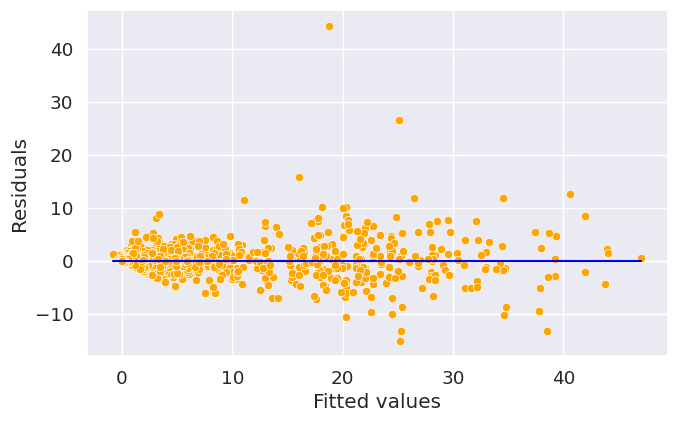

In [ ]:
res_plot(data.droprate, exog, data.totalenroll, "drop")

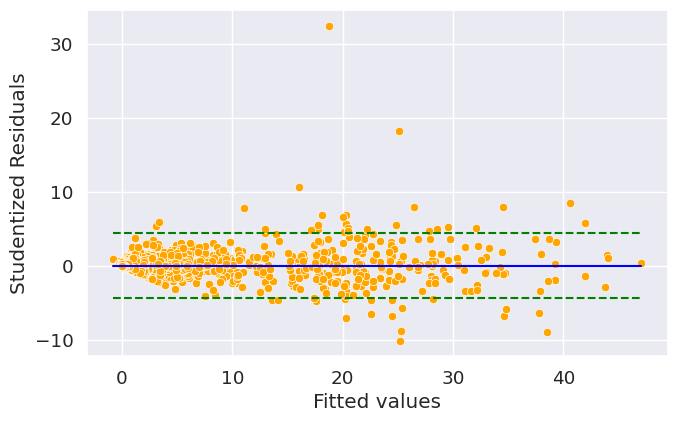

In [ ]:
studentized_res_plot(data.droprate, exog, data.totalenroll, "drop")

Critical value: 0.9996646127732068


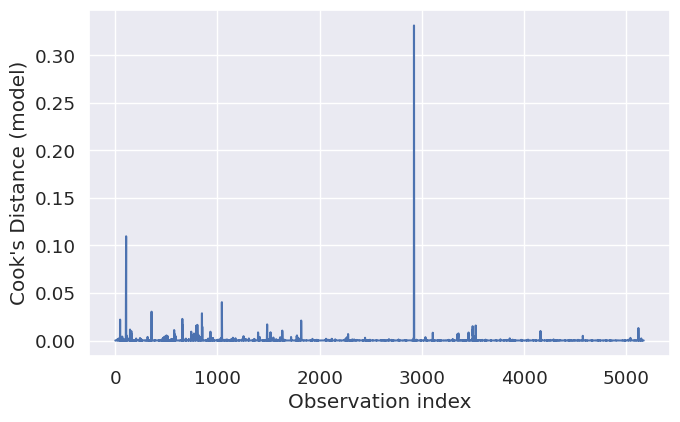

In [ ]:
cooks_distance(data.droprate, exog, data.totalenroll, "drop")

In [ ]:
res = wls_results.resid
res.apply(lambda x:np.abs(x)).sort_values(ascending = False).head(20)

2923    44.437851
106     26.565951
1043    15.857125
105     15.054082
848     13.310940
104     13.190338
355     12.568159
656     11.870766
47      11.829756
1819    11.537175
1486    10.548174
658     10.281420
1485    10.173620
3527    10.166702
803     10.138994
3497     9.905533
791      9.686738
354      9.481535
5119     8.894480
799      8.757464
dtype: float64

In [ ]:
leverage = np.diag(np.dot(np.dot(exog, np.linalg.inv(np.dot(np.transpose(exog), exog))), np.transpose(exog)))
p = exog.shape[1] - 1
mse = np.mean(res**2)
cooks_distance = (res**2 * leverage) / (p * mse * (1 - leverage)**2)
cooks_distance.sort_values(ascending = False).head(20)

2923    0.331372
106     0.109600
1043    0.040283
105     0.035178
355     0.030313
848     0.028592
104     0.027014
656     0.022714
47      0.021982
1819    0.020952
1486    0.016913
803     0.016452
658     0.016414
3527    0.015748
1485    0.015658
791     0.015536
3497    0.015024
851     0.014500
354     0.013945
5119    0.013071
dtype: float64

In [ ]:
out = [2923, 106, 1043, 105, 848, 104, 355, 656, 47, 1819, 1486, 658, 1485, 3527, 803]
drop = pd.read_csv('drop_inf_remove.csv').drop_drop.to_list()
az = pd.read_csv('arizona_dropout.csv')
co = pd.read_csv('colorado_dropout.csv')
ga = pd.read_csv('georgia_dropout.csv')
wi = pd.read_csv('wisconsin_all.csv')
data = pd.concat([az, co, ga, wi]).loc[:, ['year', 'mergecode', 'state', 'totalenroll', 'droprate',
                                            'virtualper', 'hybridper', 'black', 'hispanic',
                                            'white', 'lowincome']]

data = data.loc[~data['mergecode'].isin(drop), :].reset_index().drop(columns = 'index')
data['year'] = data['year'].astype('str')
out_code = data.iloc[out, :].mergecode.unique()

In [ ]:
out = [2923, 106, 1043, 105, 848, 104, 355, 656, 47, 1819, 1486, 658, 1485, 3527, 803]
out_code = data.iloc[out, :].mergecode.unique()
drop = pd.read_csv('drop_inf_remove.csv').drop_drop.to_list()
az = pd.read_csv('arizona_dropout.csv')
co = pd.read_csv('colorado_dropout.csv')
ga = pd.read_csv('georgia_dropout.csv')
wi = pd.read_csv('wisconsin_all.csv')
data = pd.concat([az, co, ga, wi]).loc[:, ['year', 'mergecode', 'state', 'totalenroll', 'droprate',
                                            'virtualper', 'hybridper', 'black', 'hispanic',
                                            'white', 'lowincome']]

data = data.loc[~data['mergecode'].isin(drop), :].reset_index().drop(columns = 'index')
data['year'] = data['year'].astype('str')
data.loc[~data['mergecode'].isin(out_code)]

,year,mergecode,state,totalenroll,droprate,virtualper,hybridper,black,hispanic,white,lowincome
0,17,92768-92769arizona,arizona,585,1.43,0.0,0.0,4.44,91.11,3.25,88.00
1,18,92768-92769arizona,arizona,807,1.04,0.0,0.0,5.45,89.96,3.59,88.00
2,19,92768-92769arizona,arizona,1135,1.66,0.0,0.0,5.73,89.43,3.00,88.00
3,21,92768-92769arizona,arizona,1154,4.74,0.5,0.5,7.02,71.40,17.42,88.00
4,17,4289-5454arizona,arizona,1667,1.00,0.0,0.0,10.86,64.91,19.50,62.00
...,...,...,...,...,...,...,...,...,...,...,...
5167,21,980-40wisconsin,wisconsin,299,0.33,0.0,0.0,0.87,12.50,85.47,37.21
5168,17,994-40wisconsin,wisconsin,91,0.00,0.0,0.0,0.00,0.00,100.00,43.01
5169,18,994-40wisconsin,wisconsin,99,0.00,0.0,0.0,1.01,0.00,97.98,40.40
5170,19,994-40wisconsin,wisconsin,103,0.00,0.0,0.0,1.00,0.00,98.00,57.00


In [ ]:
list(out_code)

['644-0500georgia',
 '4412-90822arizona',
 '4403-6264arizona',
 '4320-90159arizona',
 '4221-90064arizona',
 '4196-92913arizona',
 '79874-78813arizona',
 '1010-5146colorado',
 '0870-2155colorado',
 '772-0110georgia',
 '4431-5877arizona']

In [ ]:
drop = pd.read_csv('drop_inf_remove.csv').drop_drop.to_list() + list(out_code)
az = pd.read_csv('arizona_dropout.csv')
co = pd.read_csv('colorado_dropout.csv')
ga = pd.read_csv('georgia_dropout.csv')
wi = pd.read_csv('wisconsin_all.csv')
data = pd.concat([az, co, ga, wi]).loc[:, ['year', 'mergecode', 'state', 'totalenroll', 'droprate',
                                            'virtualper', 'hybridper', 'black', 'hispanic',
                                            'white', 'lowincome']]

data = data.loc[~data['mergecode'].isin(drop), :].reset_index().drop(columns = 'index')
data['year'] = data['year'].astype('str')

dummy_variables = pd.get_dummies(data[['year', 'mergecode', 'state']], drop_first = True, dtype = 'int')
data = pd.concat([data, dummy_variables], axis=1).drop(columns = ['state', 'year', 'mergecode'])
data['co_virtual'] = data['state_colorado'] * data['virtualper']
data['ga_virtual'] = data['state_georgia'] * data['virtualper']
data['wi_virtual'] = data['state_wisconsin'] * data['virtualper']
data['co_hybrid'] = data['state_colorado'] * data['hybridper']
data['ga_hybrid'] = data['state_georgia'] * data['hybridper']
data['wi_hybrid'] = data['state_wisconsin'] * data['hybridper']

data = data.drop(columns = ['state_colorado', 'state_georgia', 'state_wisconsin'])

data['black_virtual'] = data['black'] * data['virtualper']
data['black_hybrid'] = data['black'] * data['hybridper']
data['hispanic_virtual'] = data['hispanic'] * data['virtualper']
data['hispanic_hybrid'] = data['hispanic'] * data['hybridper']
# removed % ED * % Virtual
data['lowincome_hybrid'] = data['lowincome'] * data['hybridper']

exog = data.drop(columns = ['totalenroll', 'droprate'])
exog = sm.add_constant(exog)

In [ ]:
params = ['virtualper', 'hybridper', 'co_virtual', 'ga_virtual', 'wi_virtual', 'co_hybrid', 'ga_hybrid', 'wi_hybrid',
          'black_virtual', 'black_hybrid', 'hispanic_virtual', 'hispanic_hybrid', 'lowincome_hybrid']
model_assumption(data.droprate, exog, data.totalenroll, params)

Breusch-Pagan test p-value: 4.494058103995434e-129
Durbin-Watson test statistic: 2.3915183568201632
            features        vif
0         virtualper  20.015871
1          hybridper  10.439722
2         co_virtual   2.899705
3         ga_virtual   9.398449
4         wi_virtual   2.204522
5          co_hybrid   2.815810
6          ga_hybrid   4.390478
7          wi_hybrid   2.629457
8      black_virtual   6.000405
9       black_hybrid   5.014362
10  hispanic_virtual   8.067434
11   hispanic_hybrid  11.403776
12  lowincome_hybrid  11.182653


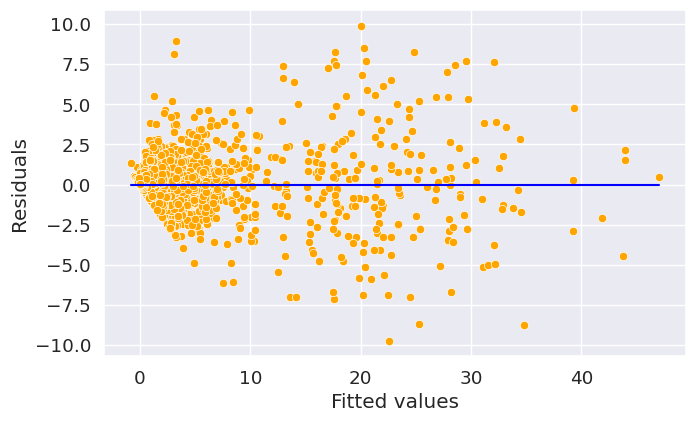

In [ ]:
res_plot(data.droprate, exog, data.totalenroll, "drop")

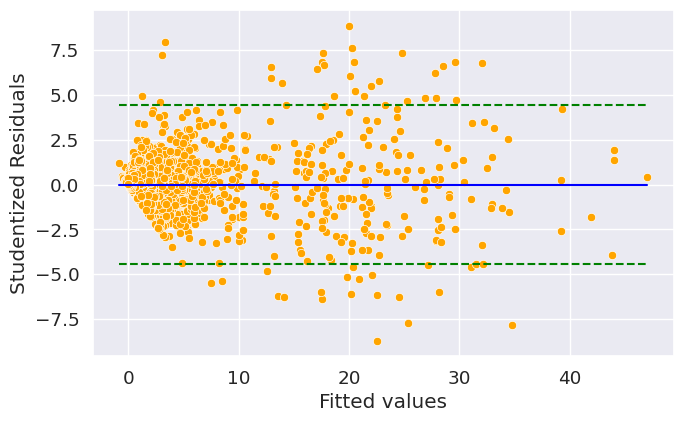

In [ ]:
studentized_res_plot(data.droprate, exog, data.totalenroll, "drop")

Critical value: 0.9996618063378057


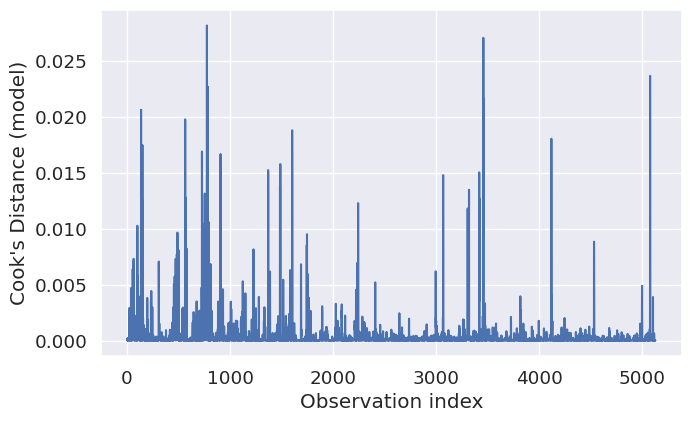

In [ ]:
cooks_distance(data.droprate, exog, data.totalenroll, "drop")

In [ ]:
drop = pd.read_csv('drop_inf_remove.csv').drop_drop.to_list() + list(out_code)
az = pd.read_csv('arizona_dropout.csv')
co = pd.read_csv('colorado_dropout.csv')
ga = pd.read_csv('georgia_dropout.csv')
wi = pd.read_csv('wisconsin_all.csv')
data = pd.concat([az, co, ga, wi]).loc[:, ['year', 'mergecode', 'state', 'totalenroll', 'droprate',
                                            'virtualper', 'hybridper', 'black', 'hispanic',
                                            'white', 'lowincome']]

data = data.loc[~data['mergecode'].isin(drop), :].reset_index().drop(columns = 'index')
data['year'] = data['year'].astype('str')

dummy_variables = pd.get_dummies(data[['year', 'mergecode', 'state']], drop_first = True, dtype = 'int')
data = pd.concat([data, dummy_variables], axis=1).drop(columns = ['state', 'year', 'mergecode'])
data['co_virtual'] = data['state_colorado'] * data['virtualper']
data['ga_virtual'] = data['state_georgia'] * data['virtualper']
data['wi_virtual'] = data['state_wisconsin'] * data['virtualper']
data['co_hybrid'] = data['state_colorado'] * data['hybridper']
data['ga_hybrid'] = data['state_georgia'] * data['hybridper']
data['wi_hybrid'] = data['state_wisconsin'] * data['hybridper']

data = data.drop(columns = ['state_colorado', 'state_georgia', 'state_wisconsin'])

data['black_virtual'] = data['black'] * data['virtualper']
data['black_hybrid'] = data['black'] * data['hybridper']
data['hispanic_virtual'] = data['hispanic'] * data['virtualper']
data['hispanic_hybrid'] = data['hispanic'] * data['hybridper']
# removed % ED * % Virtual
data['lowincome_hybrid'] = data['lowincome'] * data['hybridper']

exog = data.drop(columns = ['totalenroll', 'droprate'])
exog = sm.add_constant(exog)

In [ ]:
wls_results = sm.WLS(data.droprate, exog, weights = data.totalenroll).fit(cov_type = 'HC1')
wls_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:               droprate   R-squared:                       0.933
Model:                            WLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     67.09
Date:                Wed, 17 Apr 2024   Prob (F-statistic):               0.00
Time:                        17:08:55   Log-Likelihood:                -6874.1
No. Observations:                5128   AIC:                         1.635e+04
Df Residuals:                    3826   BIC:                         2.487e+04
Df Model:                        1301                                         
Covariance Type:                  HC1                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            4.7121      1.336      3.527      0.000       2.094       7.330
virtualper                       3.1899      0.306     10.418      0.000       2.590       3.790
hybridper                        1.0125      0.171      5.913      0.000       0.677       1.348
black                            0.0227      0.020      1.127      0.260      -0.017       0.062
hispanic                        -0.0325      0.013     -2.508      0.012      -0.058      -0.007
white                           -0.0231      0.013     -1.719      0.086      -0.049       0.003
lowincome                        0.0047      0.004      1.286      0.199      -0.002       0.012
year_18                         -0.0465      0.035     -1.345      0.179      -0.114       0.021
year_19                         -0.1587      0.038     -4.195      0.000      -0.233      -0.085
year_21                         -0.2549      0.065     -3.893      0.000      -0.383      -0.127
mergecode_0010-0212colorado      0.0922      0.543      0.170      0.865      -0.972       1.156
mergecode_0010-0263colorado      0.7194      0.916      0.785      0.432      -1.076       2.515
mergecode_0010-0309colorado      1.1142      0.747      1.492      0.136      -0.349       2.578
mergecode_0010-0503colorado     -1.5266      0.500     -3.053      0.002      -2.507      -0.547
mergecode_0010-0695colorado      1.6732      0.952      1.758      0.079      -0.192       3.539
mergecode_0010-1796colorado      1.4245      0.839      1.698      0.089      -0.220       3.069
mergecode_0010-3590colorado     -1.3075      0.617     -2.118      0.034      -2.517      -0.098
mergecode_0020-4108colorado     -1.6143      0.610     -2.645      0.008      -2.811      -0.418
mergecode_0020-5043colorado     -1.5694      0.617     -2.543      0.011      -2.779      -0.360
mergecode_0020-5816colorado      1.0311      0.516      1.997      0.046       0.019       2.043
mergecode_0020-6060colorado     -1.0543      0.655     -1.609      0.108      -2.338       0.230
mergecode_0020-6402colorado     -0.4110      0.552     -0.745      0.456      -1.493       0.671
mergecode_0020-9431colorado     -2.2455      0.633     -3.545      0.000      -3.487      -1.004
mergecode_0030-0022colorado     30.7872      0.958     32.149      0.000      28.910      32.664
mergecode_0040-1022colorado     -0.0316      0.527     -0.060      0.952      -1.065       1.002
mergecode_0040-2399colorado     -1.7721      0.565     -3.136      0.002      -2.880      -0.664
mergecode_0040-7129colorado     -0.9715      0.559     -1.739      0.082      -2.067       0.124
mergecode_0050-0775colorado     -1.2517      0.584     -2.145      0.032      -2.396      -0.108
mergecode_0060-8334colorado     -1.5578      0.684     -2.277      0.023    

In [ ]:
drop = pd.read_csv('drop_inf_remove.csv').drop_drop.to_list() + list(out_code)
az = pd.read_csv('arizona_dropout.csv')
co = pd.read_csv('colorado_dropout.csv')
ga = pd.read_csv('georgia_dropout.csv')
wi = pd.read_csv('wisconsin_all.csv')
data = pd.concat([az, co, ga, wi]).loc[:, ['year', 'mergecode', 'state', 'totalenroll', 'droprate',
                                            'virtualper', 'hybridper', 'black', 'hispanic',
                                            'white', 'lowincome']]

data = data.loc[~data['mergecode'].isin(drop), :].reset_index().drop(columns = 'index')

dummy_variables = pd.get_dummies(data[['state']], drop_first = True, dtype = 'int')
data = pd.concat([data, dummy_variables], axis=1).drop(columns = ['state'])
data['co_virtual'] = data['state_colorado'] * data['virtualper']
data['ga_virtual'] = data['state_georgia'] * data['virtualper']
data['wi_virtual'] = data['state_wisconsin'] * data['virtualper']
data['co_hybrid'] = data['state_colorado'] * data['hybridper']
data['ga_hybrid'] = data['state_georgia'] * data['hybridper']
data['wi_hybrid'] = data['state_wisconsin'] * data['hybridper']

data['year'] = pd.to_datetime(data['year'], format='%y')
data = data.drop(columns = ['state_colorado', 'state_georgia', 'state_wisconsin']).set_index(['mergecode', 'year'])

data['black_virtual'] = data['black'] * data['virtualper']
data['black_hybrid'] = data['black'] * data['hybridper']
data['hispanic_virtual'] = data['hispanic'] * data['virtualper']
data['hispanic_hybrid'] = data['hispanic'] * data['hybridper']
#data['lowincome_virtual'] = data['lowincome'] * data['virtualper']
data['lowincome_hybrid'] = data['lowincome'] * data['hybridper']

exog = data.drop(columns = ['totalenroll', 'droprate'])
exog = sm.add_constant(exog)

In [ ]:
PanelOLS(data.droprate, exog, weights = data.totalenroll, entity_effects = True, time_effects = True).fit(cov_type = 'robust')

Dep. Variable:,droprate,R-squared:,0.2410
Estimator:,PanelOLS,R-squared (Between):,0.0532
No. Observations:,5128,R-squared (Within):,0.2387
Date:,"Wed, Apr 17 2024",R-squared (Overall):,0.0697
Time:,17:27:28,Log-likelihood,-5695.8
Cov. Estimator:,Robust,,
,,F-statistic:,452.49
Entities:,1282,P-value,0.0000
Avg Obs:,4.0000,Distribution:,"F(17,3826)"
Min Obs:,4.0000,,
Max Obs:,4.0000,F-statistic (robust):,47.837


In [ ]:
coefficients = params[[1, 1291]]
covariance_matrix = cov_matrix.iloc[[1, 1291], [1, 1291]]

se_sum = np.sqrt(covariance_matrix.iloc[0, 0] + covariance_matrix.iloc[
    1, 1] + 2 * covariance_matrix.iloc[0, 1])
df = result.df_resid
alpha = 0.05
critical_value = t.ppf(1 - alpha/2, df)
margin_of_error = critical_value * se_sum
sum_of_coefficients = np.sum(coefficients)
confidence_interval = (sum_of_coefficients - margin_of_error, sum_of_coefficients + margin_of_error)
print("Confidence interval:", confidence_interval)

t_statistic = sum_of_coefficients / se_sum
p_value = 2 * (1 - t.cdf(np.abs(t_statistic), df))
print("p-value:", p_value)
print("sum:", sum_of_coefficients)

Confidence interval: (-0.36653402168225735, 0.6522810073641477)
p-value: 0.582430398692305
sum: 0.1428734928409452


In [ ]:
coefficients = params[[1, 1292]]
covariance_matrix = cov_matrix.iloc[[1, 1292], [1, 1292]]

se_sum = np.sqrt(covariance_matrix.iloc[0, 0] + covariance_matrix.iloc[
    1, 1] + 2 * covariance_matrix.iloc[0, 1])
df = result.df_resid
alpha = 0.05
critical_value = t.ppf(1 - alpha/2, df)
margin_of_error = critical_value * se_sum
sum_of_coefficients = np.sum(coefficients)
confidence_interval = (sum_of_coefficients - margin_of_error, sum_of_coefficients + margin_of_error)
print("Confidence interval:", confidence_interval)

t_statistic = sum_of_coefficients / se_sum
p_value = 2 * (1 - t.cdf(np.abs(t_statistic), df))
print("p-value:", p_value)
print("sum:", sum_of_coefficients)

Confidence interval: (0.4070647054114198, 1.452299751590154)
p-value: 0.0004927249996296013
sum: 0.9296822285007869


In [ ]:
coefficients = params[[1, 1293]]
covariance_matrix = cov_matrix.iloc[[1, 1293], [1, 1293]]

se_sum = np.sqrt(covariance_matrix.iloc[0, 0] + covariance_matrix.iloc[
    1, 1] + 2 * covariance_matrix.iloc[0, 1])
df = result.df_resid
alpha = 0.05
critical_value = t.ppf(1 - alpha/2, df)
margin_of_error = critical_value * se_sum
sum_of_coefficients = np.sum(coefficients)
confidence_interval = (sum_of_coefficients - margin_of_error, sum_of_coefficients + margin_of_error)
print("Confidence interval:", confidence_interval)

t_statistic = sum_of_coefficients / se_sum
p_value = 2 * (1 - t.cdf(np.abs(t_statistic), df))
print("p-value:", p_value)
print("sum:", sum_of_coefficients)

Confidence interval: (-0.21573285982180074, 0.6108786292632147)
p-value: 0.3487047218257935
sum: 0.197572884720707


In [ ]:
params[[2, 1294]]

hybridper    1.012483
co_hybrid   -0.997154
dtype: float64

In [ ]:
coefficients = params[[2, 1294]]
covariance_matrix = cov_matrix.iloc[[2, 1294], [2, 1294]]

se_sum = np.sqrt(covariance_matrix.iloc[0, 0] + covariance_matrix.iloc[
    1, 1] + 2 * covariance_matrix.iloc[0, 1])
df = result.df_resid
alpha = 0.05
critical_value = t.ppf(1 - alpha/2, df)
margin_of_error = critical_value * se_sum
sum_of_coefficients = np.sum(coefficients)
confidence_interval = (sum_of_coefficients - margin_of_error, sum_of_coefficients + margin_of_error)
print("Confidence interval:", confidence_interval)

t_statistic = sum_of_coefficients / se_sum
p_value = 2 * (1 - t.cdf(np.abs(t_statistic), df))
print("p-value:", p_value)
print("sum:", sum_of_coefficients)

Confidence interval: (-0.329984620184908, 0.3606417129907267)
p-value: 0.9306515269121849
sum: 0.015328546402909371


In [ ]:
coefficients = params[[2, 1295]]
covariance_matrix = cov_matrix.iloc[[2, 1295], [2, 1295]]

se_sum = np.sqrt(covariance_matrix.iloc[0, 0] + covariance_matrix.iloc[
    1, 1] + 2 * covariance_matrix.iloc[0, 1])
df = result.df_resid
alpha = 0.05
critical_value = t.ppf(1 - alpha/2, df)
margin_of_error = critical_value * se_sum
sum_of_coefficients = np.sum(coefficients)
confidence_interval = (sum_of_coefficients - margin_of_error, sum_of_coefficients + margin_of_error)
print("Confidence interval:", confidence_interval)

t_statistic = sum_of_coefficients / se_sum
p_value = 2 * (1 - t.cdf(np.abs(t_statistic), df))
print("p-value:", p_value)
print("sum:", sum_of_coefficients)

Confidence interval: (-0.19242937726248815, 0.7624649392790404)
p-value: 0.24191528236079485
sum: 0.2850177810082761


In [ ]:
coefficients = params[[2, 1296]]
covariance_matrix = cov_matrix.iloc[[2, 1296], [2, 1296]]

se_sum = np.sqrt(covariance_matrix.iloc[0, 0] + covariance_matrix.iloc[
    1, 1] + 2 * covariance_matrix.iloc[0, 1])
df = result.df_resid
alpha = 0.05
critical_value = t.ppf(1 - alpha/2, df)
margin_of_error = critical_value * se_sum
sum_of_coefficients = np.sum(coefficients)
confidence_interval = (sum_of_coefficients - margin_of_error, sum_of_coefficients + margin_of_error)
print("Confidence interval:", confidence_interval)

t_statistic = sum_of_coefficients / se_sum
p_value = 2 * (1 - t.cdf(np.abs(t_statistic), df))
print("p-value:", p_value)
print("sum:", sum_of_coefficients)

Confidence interval: (-0.8273407544199907, -0.1362726513523687)
p-value: 0.006289526427061931
sum: -0.48180670288617966


# Summary Statistics

# Math Proficiency Rate

In [ ]:
drop = pd.read_csv('math_drop.csv').math_drop.to_list()
in_math = pd.read_csv('new_indiana_mathpass.csv')
il = pd.read_csv('illinois_all.csv')
wi = pd.read_csv('wisconsin_all.csv')
data = pd.concat([in_math, il, wi]).loc[:, ['year', 'mergecode', 'state', 'totalenroll', 'mathpass',
                                            'virtualper', 'hybridper', 'black', 'hispanic',
                                            'white', 'lowincome']]
data = data.loc[~data['mergecode'].isin(drop), :].reset_index().drop(columns = 'index')

In [ ]:
data[data['year'] == 21].groupby('state').count()

,year,mergecode,totalenroll,mathpass,virtualper,hybridper,black,hispanic,white,lowincome
state,,,,,,,,,,
il,608,608,608,608,608,608,608,608,608,608
indiana,306,306,306,306,306,306,306,306,306,306
wisconsin,354,354,354,354,354,354,354,354,354,354


In [ ]:
state_year_total = data.groupby(['state', 'year']).sum().loc[:, 'totalenroll'].reset_index().rename(
    columns = {'totalenroll':'state_year_total'})
state_total = state_year_total.groupby('state').sum().loc[:, ['state_year_total']].reset_index().rename(
    columns = {'state_year_total': 'state_total'})
d1 = state_year_total.merge(data, on = ['state', 'year'])
d1['weight'] = d1['totalenroll'] / d1['state_year_total']
d1['bh'] = d1['black'] + d1['hispanic']
d1['mathpass'] = d1['mathpass'] * d1['weight']
d1['bh'] = d1['bh'] * d1['weight']
d1['lowincome'] = d1['lowincome'] * d1['weight']
d1 = d1.groupby(['state', 'year']).sum().loc[:, ['mathpass', 'bh', 'lowincome']].reset_index()
d1 = d1.merge(state_total, on = 'state').merge(state_year_total, on = ['state', 'year'])
d1['weight'] = d1['state_year_total'] / d1['state_total']
d1['mathpass'] = d1['mathpass'] * d1['weight']
d1['bh'] = d1['bh'] * d1['weight']
d1['lowincome'] = d1['lowincome'] * d1['weight']
all = d1.loc[:, ['state', 'state_total']].drop_duplicates().state_total.sum()
print(d1.groupby('state').sum())
d1 = d1.groupby('state').sum()
d1['weight'] = (state_total['state_total'] / all).to_list()
d1['mathpass'] = d1['mathpass'] * d1['weight']
d1['bh'] = d1['bh'] * d1['weight']
d1['lowincome'] = d1['lowincome'] * d1['weight']
d1.groupby('year').sum()

           year   mathpass         bh  lowincome  state_total  \
state                                                           
il           75  31.139278  39.939872  45.891054      7380632   
indiana      75  35.204715  17.708708  41.399499      3876576   
wisconsin    75  33.874715  13.008316  31.478621      2604084   

           state_year_total  weight  
state                                
il                  1845158     1.0  
indiana              969144     1.0  
wisconsin            651021     1.0  


,mathpass,bh,lowincome,state_total,state_year_total,weight
year,,,,,,
75,32.790155,28.662941,41.927279,13861292,3465323,1.0


In [ ]:
mode = data[data['year'] == 21]
state_total = mode.groupby('state').sum().loc[:, ['totalenroll']].reset_index().rename(
    columns = {'totalenroll': 'state_total'})
d1 = state_total.merge(mode, on = ['state'])
d1['weight'] = d1['totalenroll'] / d1['state_total']
d1['virtualper'] = d1['virtualper'] * d1['weight']
d1['hybridper'] = d1['hybridper'] * d1['weight']
print(d1.groupby('state').sum().loc[:, ['virtualper', 'hybridper']])
all = state_total.state_total.sum()
d1 = d1.groupby('state').sum().loc[:, ['virtualper', 'hybridper']]
d1['weight'] = list(state_total['state_total'] / all)
d1['virtualper'] = d1['virtualper'] * d1['weight']
d1['hybridper'] = d1['hybridper'] * d1['weight']
d1.sum()

           virtualper  hybridper
state                           
il           0.337472   0.476913
indiana      0.138434   0.071631
wisconsin    0.138039   0.223012


virtualper    0.243821
hybridper     0.314805
weight        1.000000
dtype: float64

# ELA Proficiency Rate

In [ ]:
drop = pd.read_csv('ela_inf_remove.csv').ela_drop.to_list()
in_ela = pd.read_csv('new_indiana_elapass.csv')
il = pd.read_csv('illinois_all.csv')
wi = pd.read_csv('wisconsin_all.csv')
data = pd.concat([in_ela, il, wi]).loc[:, ['year', 'mergecode', 'state', 'totalenroll', 'elapass',
                                            'virtualper', 'hybridper', 'black', 'hispanic',
                                            'white', 'lowincome']]
data = data.loc[~data['mergecode'].isin(drop), :].reset_index().drop(columns = 'index')

In [ ]:
data[data['year'] == 21].groupby('state').count()

,year,mergecode,totalenroll,elapass,virtualper,hybridper,black,hispanic,white,lowincome
state,,,,,,,,,,
il,656,656,656,656,656,656,656,656,656,656
indiana,317,317,317,317,317,317,317,317,317,317
wisconsin,355,355,355,355,355,355,355,355,355,355


In [ ]:
state_year_total = data.groupby(['state', 'year']).sum().loc[:, 'totalenroll'].reset_index().rename(
    columns = {'totalenroll':'state_year_total'})
state_total = state_year_total.groupby('state').sum().loc[:, ['state_year_total']].reset_index().rename(
    columns = {'state_year_total': 'state_total'})
d1 = state_year_total.merge(data, on = ['state', 'year'])
d1['weight'] = d1['totalenroll'] / d1['state_year_total']
d1['bh'] = d1['black'] + d1['hispanic']
d1['elapass'] = d1['elapass'] * d1['weight']
d1['bh'] = d1['bh'] * d1['weight']
d1['lowincome'] = d1['lowincome'] * d1['weight']
d1 = d1.groupby(['state', 'year']).sum().loc[:, ['elapass', 'bh', 'lowincome']].reset_index()
d1 = d1.merge(state_total, on = 'state').merge(state_year_total, on = ['state', 'year'])
d1['weight'] = d1['state_year_total'] / d1['state_total']
d1['elapass'] = d1['elapass'] * d1['weight']
d1['bh'] = d1['bh'] * d1['weight']
d1['lowincome'] = d1['lowincome'] * d1['weight']
all = d1.loc[:, ['state', 'state_total']].drop_duplicates().state_total.sum()
print(d1.groupby('state').sum())
d1 = d1.groupby('state').sum()
d1['weight'] = (state_total['state_total'] / all).to_list()
d1['elapass'] = d1['elapass'] * d1['weight']
d1['bh'] = d1['bh'] * d1['weight']
d1['lowincome'] = d1['lowincome'] * d1['weight']
d1.groupby('year').sum()

           year    elapass         bh  lowincome  state_total  \
state                                                           
il           75  35.637462  40.248767  43.659375      8903752   
indiana      75  62.116316  17.526191  39.972224      4216388   
wisconsin    75  38.358381  14.720465  32.741394      2639836   

           state_year_total  weight  
state                                
il                  2225938     1.0  
indiana             1054097     1.0  
wisconsin            659959     1.0  


,elapass,bh,lowincome,state_total,state_year_total,weight
year,,,,,,
75,43.177315,29.893565,40.844134,15759976,3939994,1.0


In [ ]:
mode = data[data['year'] == 21]
state_total = mode.groupby('state').sum().loc[:, ['totalenroll']].reset_index().rename(
    columns = {'totalenroll': 'state_total'})
d1 = state_total.merge(mode, on = ['state'])
d1['weight'] = d1['totalenroll'] / d1['state_total']
d1['virtualper'] = d1['virtualper'] * d1['weight']
d1['hybridper'] = d1['hybridper'] * d1['weight']
print(d1.groupby('state').sum().loc[:, ['virtualper', 'hybridper']])
all = state_total.state_total.sum()
d1 = d1.groupby('state').sum().loc[:, ['virtualper', 'hybridper']]
d1['weight'] = list(state_total['state_total'] / all)
d1['virtualper'] = d1['virtualper'] * d1['weight']
d1['hybridper'] = d1['hybridper'] * d1['weight']
d1.sum()

           virtualper  hybridper
state                           
il           0.343295   0.501046
indiana      0.147590   0.076600
wisconsin    0.158914   0.222700


virtualper    0.259584
hybridper     0.339799
weight        1.000000
dtype: float64

# Dropout Rate

In [ ]:
drop = pd.read_csv('drop_inf_remove.csv').drop_drop.to_list() + ['644-0500georgia', '4412-90822arizona', '4403-6264arizona',
       '4320-90159arizona', '4221-90064arizona', '4196-92913arizona',
       '79874-78813arizona', '1010-5146colorado', '0870-2155colorado',
       '772-0110georgia', '4431-5877arizona']
az = pd.read_csv('arizona_dropout.csv')
co = pd.read_csv('colorado_dropout.csv')
ga = pd.read_csv('georgia_dropout.csv')
wi = pd.read_csv('wisconsin_all.csv')
data = pd.concat([az, co, ga, wi]).loc[:, ['year', 'mergecode', 'state', 'totalenroll', 'droprate',
                                            'virtualper', 'hybridper', 'black', 'hispanic',
                                            'white', 'lowincome']]

data = data.loc[~data['mergecode'].isin(drop), :].reset_index().drop(columns = 'index')

In [ ]:
data[data['year'] == 21].groupby('state').count()

,year,mergecode,totalenroll,droprate,virtualper,hybridper,black,hispanic,white,lowincome
state,,,,,,,,,,
arizona,282,282,282,282,282,282,282,282,282,282
colorado,366,366,366,366,366,366,366,366,366,366
georgia,228,228,228,228,228,228,228,228,228,228
wisconsin,406,406,406,406,406,406,406,406,406,406


In [ ]:
state_year_total = data.groupby(['state', 'year']).sum().loc[:, 'totalenroll'].reset_index().rename(
    columns = {'totalenroll':'state_year_total'})
state_total = state_year_total.groupby('state').sum().loc[:, ['state_year_total']].reset_index().rename(
    columns = {'state_year_total': 'state_total'})
d1 = state_year_total.merge(data, on = ['state', 'year'])
d1['weight'] = d1['totalenroll'] / d1['state_year_total']
d1['bh'] = d1['black'] + d1['hispanic']
d1['droprate'] = d1['droprate'] * d1['weight']
d1['bh'] = d1['bh'] * d1['weight']
d1['lowincome'] = d1['lowincome'] * d1['weight']
d1 = d1.groupby(['state', 'year']).sum().loc[:, ['droprate', 'bh', 'lowincome']].reset_index()
d1 = d1.merge(state_total, on = 'state').merge(state_year_total, on = ['state', 'year'])
d1['weight'] = d1['state_year_total'] / d1['state_total']
d1['droprate'] = d1['droprate'] * d1['weight']
d1['bh'] = d1['bh'] * d1['weight']
d1['lowincome'] = d1['lowincome'] * d1['weight']
all = d1.loc[:, ['state', 'state_total']].drop_duplicates().state_total.sum()
print(d1.groupby('state').sum())
d1 = d1.groupby('state').sum()
d1['weight'] = (state_total['state_total'] / all).to_list()
d1['droprate'] = d1['droprate'] * d1['weight']
d1['bh'] = d1['bh'] * d1['weight']
d1['lowincome'] = d1['lowincome'] * d1['weight']
d1.groupby('year').sum()

           year  droprate         bh  lowincome  state_total  \
state                                                          
arizona      75  2.825428  53.979162  50.579025      4674932   
colorado     75  1.678821  36.894539  36.371735      4540908   
georgia      75  2.732041  53.441114  51.964104      5944436   
wisconsin    75  1.095902  16.482512  33.028649      3604056   

           state_year_total  weight  
state                                
arizona             1168733     1.0  
colorado            1135227     1.0  
georgia             1486109     1.0  
wisconsin            901014     1.0  


,droprate,bh,lowincome,state_total,state_year_total,weight
year,,,,,,
75,2.186179,42.472324,44.2088,18764332,4691083,1.0


In [ ]:
mode = data[data['year'] == 21]
state_total = mode.groupby('state').sum().loc[:, ['totalenroll']].reset_index().rename(
    columns = {'totalenroll': 'state_total'})
d1 = state_total.merge(mode, on = ['state'])
d1['weight'] = d1['totalenroll'] / d1['state_total']
d1['virtualper'] = d1['virtualper'] * d1['weight']
d1['hybridper'] = d1['hybridper'] * d1['weight']
print(d1.groupby('state').sum().loc[:, ['virtualper', 'hybridper']])
all = state_total.state_total.sum()
d1 = d1.groupby('state').sum().loc[:, ['virtualper', 'hybridper']]
d1['weight'] = list(state_total['state_total'] / all)
d1['virtualper'] = d1['virtualper'] * d1['weight']
d1['hybridper'] = d1['hybridper'] * d1['weight']
d1.sum()

           virtualper  hybridper
state                           
arizona      0.415401   0.566855
colorado     0.297241   0.428080
georgia      0.333665   0.215756
wisconsin    0.184892   0.292175


virtualper    0.316170
hybridper     0.368267
weight        1.000000
dtype: float64